# Neural Network

In [1]:
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

import yaml

import matplotlib.pyplot as plt

In [2]:
hparams = yaml.safe_load(open('../src/models/hparams.yaml'))

hparams

{'learning_rate': 0.01, 'batch_size': 16, 'num_hidden_layers': 4}

In [3]:
wiki_df = pd.read_csv('../data/processed/wiki_df.csv', sep=';')

wiki_df.head()

,full_path,gender,age,img_array
0,17/10000217_1981-05-05_2009.jpg,1.0,28,[255 255 255 ... 144 78 27]
1,12/100012_1948-07-03_2008.jpg,1.0,60,[92 98 93 ... 35 31 30]
2,16/10002116_1971-05-31_2012.jpg,0.0,41,[ 10 30 61 ... 231 237 255]
3,02/10002702_1960-11-09_2012.jpg,0.0,52,[178 122 97 ... 168 112 83]
4,41/10003541_1937-09-27_1971.jpg,1.0,34,[194 189 190 ... 101 103 104]


In [33]:
# Noramalize image values on range <0.0;1.0>
# check: https://www.tensorflow.org/tutorials/images/cnn
#wiki_df['img_array'] = wiki_df['img_array'] / 255.0
#wiki_df.head()

In [54]:
import cv2

wiki_df['img_array'] = wiki_df['full_path'].apply(lambda x: np.array(cv2.resize(cv2.imread('../data/raw/wiki_crop/' + x), (224, 224), interpolation=cv2.INTER_LINEAR).reshape(1, -1)[0]))

## Experiment 1

* Ako prvé sa pokúsime vytvoriť NN podobnú VGG. Podľa [WEEK_7 lab](https://github.com/matus-pikuliak/neural_networks_at_fiit/blob/92b24eef8e6444c43a22e8fa51a349b3b1043a7c/week_7/week_7.ipynb), alebo iného tutoriálu
* Natrénujeme ju na už predspracovanom datasete
* Jej výsledok pou%zijeme ako štartovaciu čiaru
* Túto sieť budeme rozširovať o ďalšie vrstvy a parametre
* V projekte ponecháme sieť s najlepším skóre
* Dole pripájam referenčnú ukážku siete. [Zdroj](https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/?__s)

In [4]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout


class MiniVGGNetModel(keras.Model):
    def __init__(self, classes, chanDim=-1):
        # call the parent constructor
        super(MiniVGGNetModel, self).__init__()

        # initialize the layers in the first (CONV => RELU) * 2 => POOL
        # layer set
        self.conv1A = Conv2D(32, (3, 3), padding="same")
        self.act1A = Activation("relu")
        self.bn1A = BatchNormalization(axis=chanDim)
        self.conv1B = Conv2D(32, (3, 3), padding="same")
        self.act1B = Activation("relu")
        self.bn1B = BatchNormalization(axis=chanDim)
        self.pool1 = MaxPooling2D(pool_size=(2, 2))

        # initialize the layers in the second (CONV => RELU) * 2 => POOL
        # layer set
        self.conv2A = Conv2D(32, (3, 3), padding="same")
        self.act2A = Activation("relu")
        self.bn2A = BatchNormalization(axis=chanDim)
        self.conv2B = Conv2D(32, (3, 3), padding="same")
        self.act2B = Activation("relu")
        self.bn2B = BatchNormalization(axis=chanDim)
        self.pool2 = MaxPooling2D(pool_size=(2, 2))

        # initialize the layers in our fully-connected layer set
        self.flatten = Flatten()
        self.dense3 = Dense(512)
        self.act3 = Activation("relu")
        self.bn3 = BatchNormalization()
        self.do3 = Dropout(0.5)

        # initialize the layers in the softmax classifier layer set
        self.dense4 = Dense(classes)
        self.softmax = Activation("softmax")

    def call(self, inputs):
        # build the first (CONV => RELU) * 2 => POOL layer set
        x = self.conv1A(inputs)
        x = self.act1A(x)
        x = self.bn1A(x)
        x = self.conv1B(x)
        x = self.act1B(x)
        x = self.bn1B(x)
        x = self.pool1(x)

        # build the second (CONV => RELU) * 2 => POOL layer set
        x = self.conv2A(x)
        x = self.act2A(x)
        x = self.bn2A(x)
        x = self.conv2B(x)
        x = self.act2B(x)
        x = self.bn2B(x)
        x = self.pool2(x)

        # build our FC layer set
        x = self.flatten(x)
        x = self.dense3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.do3(x)

        # build the softmax classifier
        x = self.dense4(x)
        x = self.softmax(x)

        # return the constructed model
        return x

In [5]:
target = wiki_df['age'].values


17/10000217_1981-05-05_2009.jpg
(224, 224, 3)
float32


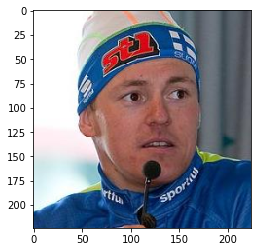

In [6]:
##########################

path = wiki_df['full_path'][0]

print(path)

import cv2
def load_img(x):
    im = cv2.imread('../data/raw/wiki_crop/' + x)
    im = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #im = im.reshape(1, -1)[0]
    #return np.array(im)
    return (np.array(im) / 255.0).astype(np.float32)

#wiki_df['img_array'] = wiki_df['full_path'].apply(load_img)

im = load_img(path)

print(im.shape)
print(im.dtype)

plt.figure()
plt.imshow(im)
plt.show()

##########################

In [7]:
wiki_df = wiki_df.drop(['img_array'], axis=1)
wiki_df

,full_path,gender,age
0,17/10000217_1981-05-05_2009.jpg,1.0,28
1,12/100012_1948-07-03_2008.jpg,1.0,60
2,16/10002116_1971-05-31_2012.jpg,0.0,41
3,02/10002702_1960-11-09_2012.jpg,0.0,52
4,41/10003541_1937-09-27_1971.jpg,1.0,34
...,...,...,...
22573,38/9996938_1937-02-15_1968.jpg,1.0,31
22574,46/9996946_1943-11-01_1968.jpg,1.0,25
22575,49/9996949_1937-04-17_1963.jpg,1.0,26
22576,09/9998109_1972-12-27_2013.jpg,1.0,41


In [29]:
#wiki_df['img_array'] = wiki_df['full_path'].apply(load_img)

import gc

features = []
for i in range(22578):
    features.append(None)
    
features = np.array(features)

for i in range(0, len(wiki_df['full_path'].values)):
    if i%500 == 0:
        gc.collect()
        print(i)
    path = wiki_df['full_path'].values[i]
    features[i] = load_img(path)
    #features.append(load_img(path))

#features = np.array(features)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500


In [8]:
#wiki_df['img_array'] = wiki_df['full_path'].apply(load_img)

import gc

tmp = []
tmp.append(load_img(wiki_df['full_path'].values[0]))
features = np.array(tmp)

for i in range(1, len(wiki_df['full_path'].values)):
    
    path = wiki_df['full_path'].values[i]
    tmp.append(load_img(path))
    
    if i%500 == 0:
        features = np.concatenate((features, np.array(tmp)))
        tmp = []
        gc.collect()
        print(i)
        
features = np.concatenate((features, tmp))
tmp = []
        

#features = np.array(features)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000


MemoryError: Unable to allocate array with shape (19502, 224, 224, 3) and data type float32

In [9]:
features.shape

AttributeError: 'list' object has no attribute 'shape'

(22578,)

In [10]:
classes = 101 #0 to 100
target = wiki_df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

#features = [] 
#for i in range(0, len(wiki_df['img_array'].values)):
#    features.append(wiki_df['img_array'].values[i])
 
#features = np.array(features)
#features = features.reshape(features.shape[0], 224, 224, 3)

#features = wiki_df['img_array'].values
#features = features / 255.0
#features = features.reshape(features.shape[0], 224, 224, 3)

AttributeError: 'list' object has no attribute 'shape'

In [11]:
print(len(wiki_df['img_array'].values))
print(len(target_classes))
print(len(features))
print((features.shape))

KeyError: 'img_array'

In [12]:
split = int(22578/2)

train_images = features[0:split]
#train_images = train_images / 255.0
train_labels = target_classes[0:split]

test_images = features[split:]
#test_images = test_images / 255.0
test_labels = target_classes[split:]

In [15]:
HACK = int(22578/6)

for i in range(6):
    start = i*HACK
    end = (i+1)*HACK

    train_images[start:end] = train_images[start:end] / 255.0
    test_images[start:end] = test_images[start:end] / 255.0

In [13]:
test_images[150]

array([[[0.5019608 , 0.5058824 , 0.44313726],
        [0.5019608 , 0.5058824 , 0.44313726],
        [0.5019608 , 0.50980395, 0.44313726],
        ...,
        [0.61960787, 0.6313726 , 0.52156866],
        [0.61960787, 0.6313726 , 0.52156866],
        [0.627451  , 0.6392157 , 0.5254902 ]],

       [[0.49803922, 0.5019608 , 0.4392157 ],
        [0.5019608 , 0.5058824 , 0.44313726],
        [0.5019608 , 0.5058824 , 0.44313726],
        ...,
        [0.62352943, 0.63529414, 0.5254902 ],
        [0.62352943, 0.63529414, 0.52156866],
        [0.62352943, 0.63529414, 0.5294118 ]],

       [[0.49411765, 0.49803922, 0.43529412],
        [0.49803922, 0.5019608 , 0.4392157 ],
        [0.49803922, 0.5019608 , 0.4392157 ],
        ...,
        [0.627451  , 0.6392157 , 0.53333336],
        [0.62352943, 0.63529414, 0.5294118 ],
        [0.61960787, 0.6313726 , 0.53333336]],

       ...,

       [[0.24313726, 0.5176471 , 0.34509805],
        [0.2509804 , 0.52156866, 0.3529412 ],
        [0.2627451 , 0

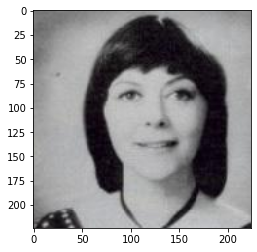

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(test_images[0])
plt.show()

In [15]:
model = MiniVGGNetModel(
    classes = classes)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

callbacks = [
    #keras.callbacks.TensorBoard(
    #    log_dir=os.path.join("logs", timestamp()),
    #    histogram_freq=1,
    #    profile_batch=0)
]

# callbacks = []  # If you do not want to log results into TensorBoard

scores = []
epochs = 60
batch_size = 64

score = model.fit(
    x=train_images,
    y=train_labels,
    batch_size = batch_size,
    validation_data = (test_images, test_labels),
    callbacks = callbacks,
    epochs = epochs)

scores.append(score)

model.summary()  # Writes number of parameters for each layer at the end of the training

ValueError: in converted code:

    <ipython-input-4-7fe3c9ba7f72>:43 call  *
        x = self.conv1A(inputs)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:812 __call__
        self.name)
    /home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/input_spec.py:155 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer conv2d expects 1 inputs, but it received 11289 input tensors. Inputs received: [<tf.Tensor 'input_1:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_12:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_13:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_14:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_15:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_16:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_17:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_18:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_19:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_20:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_21:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_22:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_23:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_24:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_25:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_26:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_27:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_28:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_29:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_30:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_31:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_32:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_33:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_34:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_35:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_36:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_37:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_38:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_39:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_40:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_41:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_42:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_43:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_44:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_45:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_46:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_47:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_48:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_49:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_50:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_51:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_52:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_53:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_54:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_55:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_56:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_57:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_58:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_59:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_60:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_61:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_62:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_63:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_64:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_65:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_66:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_67:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_68:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_69:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_70:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_71:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_72:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_73:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_74:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_75:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_76:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_77:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_78:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_79:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_80:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_81:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_82:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_83:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_84:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_85:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_86:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_87:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_88:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_89:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_90:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_91:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_92:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_93:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_94:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_95:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_96:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_97:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_98:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_99:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_1999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_2999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_3999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_4999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_5999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_6999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_7999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_8999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_9999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10289:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10290:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10291:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10292:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10293:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10294:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10295:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10296:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10297:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10298:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10299:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10300:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10301:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10302:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10303:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10304:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10305:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10306:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10307:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10308:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10309:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10310:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10311:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10312:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10313:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10314:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10315:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10316:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10317:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10318:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10319:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10320:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10321:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10322:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10323:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10324:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10325:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10326:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10327:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10328:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10329:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10330:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10331:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10332:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10333:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10334:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10335:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10336:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10337:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10338:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10339:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10340:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10341:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10342:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10343:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10344:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10345:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10346:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10347:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10348:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10349:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10350:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10351:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10352:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10353:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10354:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10355:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10356:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10357:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10358:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10359:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10360:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10361:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10362:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10363:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10364:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10365:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10366:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10367:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10368:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10369:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10370:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10371:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10372:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10373:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10374:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10375:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10376:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10377:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10378:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10379:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10380:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10381:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10382:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10383:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10384:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10385:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10386:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10387:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10388:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10389:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10390:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10391:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10392:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10393:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10394:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10395:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10396:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10397:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10398:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10399:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10400:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10401:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10402:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10403:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10404:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10405:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10406:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10407:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10408:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10409:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10410:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10411:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10412:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10413:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10414:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10415:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10416:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10417:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10418:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10419:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10420:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10421:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10422:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10423:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10424:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10425:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10426:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10427:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10428:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10429:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10430:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10431:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10432:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10433:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10434:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10435:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10436:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10437:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10438:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10439:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10440:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10441:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10442:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10443:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10444:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10445:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10446:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10447:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10448:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10449:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10450:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10451:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10452:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10453:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10454:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10455:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10456:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10457:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10458:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10459:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10460:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10461:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10462:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10463:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10464:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10465:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10466:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10467:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10468:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10469:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10470:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10471:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10472:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10473:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10474:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10475:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10476:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10477:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10478:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10479:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10480:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10481:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10482:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10483:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10484:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10485:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10486:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10487:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10488:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10489:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10490:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10491:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10492:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10493:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10494:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10495:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10496:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10497:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10498:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10499:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10500:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10501:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10502:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10503:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10504:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10505:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10506:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10507:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10508:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10509:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10510:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10511:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10512:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10513:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10514:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10515:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10516:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10517:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10518:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10519:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10520:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10521:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10522:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10523:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10524:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10525:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10526:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10527:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10528:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10529:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10530:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10531:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10532:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10533:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10534:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10535:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10536:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10537:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10538:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10539:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10540:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10541:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10542:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10543:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10544:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10545:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10546:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10547:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10548:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10549:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10550:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10551:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10552:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10553:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10554:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10555:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10556:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10557:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10558:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10559:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10560:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10561:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10562:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10563:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10564:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10565:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10566:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10567:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10568:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10569:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10570:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10571:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10572:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10573:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10574:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10575:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10576:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10577:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10578:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10579:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10580:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10581:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10582:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10583:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10584:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10585:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10586:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10587:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10588:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10589:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10590:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10591:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10592:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10593:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10594:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10595:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10596:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10597:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10598:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10599:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10600:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10601:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10602:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10603:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10604:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10605:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10606:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10607:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10608:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10609:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10610:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10611:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10612:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10613:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10614:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10615:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10616:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10617:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10618:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10619:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10620:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10621:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10622:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10623:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10624:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10625:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10626:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10627:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10628:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10629:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10630:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10631:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10632:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10633:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10634:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10635:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10636:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10637:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10638:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10639:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10640:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10641:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10642:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10643:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10644:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10645:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10646:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10647:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10648:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10649:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10650:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10651:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10652:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10653:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10654:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10655:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10656:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10657:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10658:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10659:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10660:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10661:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10662:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10663:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10664:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10665:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10666:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10667:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10668:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10669:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10670:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10671:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10672:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10673:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10674:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10675:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10676:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10677:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10678:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10679:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10680:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10681:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10682:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10683:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10684:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10685:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10686:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10687:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10688:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10689:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10690:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10691:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10692:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10693:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10694:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10695:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10696:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10697:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10698:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10699:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10700:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10701:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10702:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10703:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10704:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10705:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10706:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10707:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10708:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10709:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10710:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10711:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10712:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10713:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10714:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10715:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10716:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10717:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10718:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10719:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10720:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10721:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10722:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10723:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10724:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10725:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10726:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10727:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10728:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10729:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10730:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10731:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10732:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10733:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10734:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10735:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10736:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10737:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10738:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10739:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10740:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10741:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10742:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10743:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10744:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10745:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10746:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10747:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10748:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10749:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10750:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10751:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10752:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10753:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10754:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10755:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10756:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10757:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10758:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10759:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10760:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10761:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10762:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10763:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10764:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10765:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10766:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10767:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10768:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10769:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10770:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10771:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10772:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10773:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10774:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10775:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10776:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10777:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10778:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10779:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10780:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10781:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10782:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10783:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10784:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10785:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10786:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10787:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10788:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10789:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10790:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10791:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10792:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10793:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10794:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10795:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10796:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10797:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10798:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10799:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10800:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10801:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10802:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10803:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10804:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10805:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10806:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10807:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10808:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10809:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10810:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10811:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10812:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10813:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10814:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10815:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10816:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10817:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10818:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10819:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10820:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10821:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10822:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10823:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10824:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10825:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10826:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10827:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10828:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10829:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10830:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10831:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10832:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10833:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10834:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10835:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10836:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10837:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10838:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10839:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10840:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10841:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10842:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10843:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10844:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10845:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10846:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10847:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10848:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10849:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10850:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10851:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10852:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10853:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10854:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10855:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10856:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10857:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10858:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10859:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10860:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10861:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10862:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10863:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10864:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10865:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10866:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10867:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10868:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10869:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10870:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10871:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10872:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10873:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10874:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10875:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10876:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10877:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10878:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10879:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10880:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10881:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10882:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10883:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10884:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10885:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10886:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10887:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10888:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10889:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10890:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10891:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10892:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10893:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10894:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10895:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10896:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10897:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10898:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10899:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10900:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10901:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10902:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10903:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10904:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10905:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10906:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10907:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10908:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10909:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10910:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10911:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10912:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10913:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10914:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10915:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10916:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10917:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10918:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10919:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10920:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10921:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10922:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10923:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10924:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10925:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10926:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10927:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10928:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10929:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10930:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10931:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10932:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10933:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10934:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10935:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10936:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10937:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10938:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10939:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10940:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10941:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10942:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10943:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10944:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10945:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10946:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10947:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10948:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10949:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10950:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10951:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10952:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10953:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10954:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10955:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10956:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10957:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10958:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10959:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10960:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10961:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10962:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10963:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10964:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10965:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10966:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10967:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10968:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10969:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10970:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10971:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10972:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10973:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10974:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10975:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10976:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10977:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10978:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10979:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10980:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10981:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10982:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10983:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10984:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10985:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10986:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10987:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10988:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10989:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10990:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10991:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10992:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10993:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10994:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10995:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10996:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10997:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10998:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_10999:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11000:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11001:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11002:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11003:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11004:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11005:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11006:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11007:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11008:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11009:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11010:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11011:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11012:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11013:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11014:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11015:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11016:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11017:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11018:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11019:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11020:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11021:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11022:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11023:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11024:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11025:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11026:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11027:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11028:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11029:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11030:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11031:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11032:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11033:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11034:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11035:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11036:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11037:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11038:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11039:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11040:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11041:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11042:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11043:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11044:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11045:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11046:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11047:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11048:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11049:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11050:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11051:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11052:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11053:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11054:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11055:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11056:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11057:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11058:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11059:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11060:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11061:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11062:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11063:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11064:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11065:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11066:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11067:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11068:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11069:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11070:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11071:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11072:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11073:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11074:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11075:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11076:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11077:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11078:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11079:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11080:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11081:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11082:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11083:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11084:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11085:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11086:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11087:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11088:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11089:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11090:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11091:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11092:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11093:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11094:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11095:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11096:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11097:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11098:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11099:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11100:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11101:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11102:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11103:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11104:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11105:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11106:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11107:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11108:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11109:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11110:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11111:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11112:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11113:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11114:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11115:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11116:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11117:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11118:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11119:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11120:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11121:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11122:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11123:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11124:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11125:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11126:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11127:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11128:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11129:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11130:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11131:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11132:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11133:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11134:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11135:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11136:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11137:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11138:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11139:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11140:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11141:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11142:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11143:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11144:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11145:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11146:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11147:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11148:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11149:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11150:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11151:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11152:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11153:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11154:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11155:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11156:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11157:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11158:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11159:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11160:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11161:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11162:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11163:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11164:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11165:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11166:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11167:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11168:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11169:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11170:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11171:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11172:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11173:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11174:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11175:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11176:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11177:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11178:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11179:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11180:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11181:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11182:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11183:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11184:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11185:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11186:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11187:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11188:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11189:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11190:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11191:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11192:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11193:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11194:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11195:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11196:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11197:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11198:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11199:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11200:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11201:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11202:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11203:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11204:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11205:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11206:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11207:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11208:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11209:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11210:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11211:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11212:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11213:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11214:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11215:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11216:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11217:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11218:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11219:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11220:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11221:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11222:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11223:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11224:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11225:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11226:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11227:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11228:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11229:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11230:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11231:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11232:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11233:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11234:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11235:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11236:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11237:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11238:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11239:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11240:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11241:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11242:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11243:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11244:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11245:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11246:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11247:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11248:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11249:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11250:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11251:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11252:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11253:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11254:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11255:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11256:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11257:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11258:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11259:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11260:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11261:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11262:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11263:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11264:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11265:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11266:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11267:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11268:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11269:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11270:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11271:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11272:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11273:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11274:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11275:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11276:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11277:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11278:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11279:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11280:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11281:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11282:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11283:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11284:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11285:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11286:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11287:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11288:0' shape=(None, 224, 3) dtype=float32>, <tf.Tensor 'input_11289:0' shape=(None, 224, 3) dtype=float32>]


# Experiment 2
Cely VGG model.

Zdroj: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(keras.layers.Convolution2D(4096, (7, 7), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Convolution2D(4096, (1, 1), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Convolution2D(2622, (1, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Activation('softmax'))

In [7]:
model.load_weights('../data/vgg_face_weights.h5')

In [45]:
vgg_face_descriptor = keras.Model(inputs=model.layers[0].input, outputs=model.layers[-1].output)

Convert image as array using opencv

In [59]:
classes = 101 #0 to 100
target = wiki_df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

features = []
 
for i in range(0, 1):
    features.append(wiki_df['img_array'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [54]:
for layer in model.layers[:-7]:
    layer.trainable = False

In [56]:
base_model_output = keras.models.Sequential()
base_model_output = keras.layers.Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = keras.layers.Flatten()(base_model_output)
base_model_output = keras.layers.Activation('softmax')(base_model_output)

In [58]:
age_model = keras.Model(inputs=model.input, outputs=base_model_output)

In [63]:
age_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
 
scores = []
epochs = 250; batch_size = 256
 
for i in range(epochs):
    print("epoch ",i)
 
ix_train = np.random.choice(train_x.shape[0], size=batch_size)
 
score = age_model.fit(train_x[ix_train], train_y[ix_train], epochs=1, validation_data=(test_x, test_y))
 
scores.append(score)

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49
epoch  50
epoch  51
epoch  52
epoch  53
epoch  54
epoch  55
epoch  56
epoch  57
epoch  58
epoch  59
epoch  60
epoch  61
epoch  62
epoch  63
epoch  64
epoch  65
epoch  66
epoch  67
epoch  68
epoch  69
epoch  70
epoch  71
epoch  72
epoch  73
epoch  74
epoch  75
epoch  76
epoch  77
epoch  78
epoch  79
epoch  80
epoch  81
epoch  82
epoch  83
epoch  84
epoch  85
epoch  86
epoch  87
epoch  88
epoch  89
epoch  90
epoch  91
epoch  92
epoch  93
epoch  94
epoch  95
epoch  96
epoch  97
epoch  98
epoch  99
epoch  100

KeyboardInterrupt: 